In [2]:
import _init_path
import argparse
import datetime
import glob
import os
import re
import time
from pathlib import Path

import numpy as np
import torch
from tensorboardX import SummaryWriter
from tqdm import tqdm

from eval_utils import eval_utils
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets import build_dataloader
from mtr.models import model as model_utils
from mtr.utils import common_utils

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/home/linlongzhong/anaconda3/envs/mtr/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
parser = argparse.ArgumentParser(description='arg parser')
parser.add_argument('--cfg_file', type=str, default=None, help='specify the config for training')

parser.add_argument('--batch_size', type=int, default=None, required=False, help='batch size for training')
parser.add_argument('--workers', type=int, default=4, help='number of workers for dataloader')
parser.add_argument('--extra_tag', type=str, default='default', help='extra tag for this experiment')
parser.add_argument('--ckpt', type=str, default=None, help='checkpoint to start from')
parser.add_argument('--launcher', choices=['none', 'pytorch', 'slurm'], default='none')
parser.add_argument('--tcp_port', type=int, default=18888, help='tcp port for distrbuted training')
parser.add_argument('--local_rank', type=int, default=0, help='local rank for distributed training')
parser.add_argument('--fix_random_seed', action='store_true', default=False, help='')
parser.add_argument('--set', dest='set_cfgs', default=None, nargs=argparse.REMAINDER,
                    help='set extra config keys if needed')

parser.add_argument('--max_waiting_mins', type=int, default=30, help='max waiting minutes')
parser.add_argument('--start_epoch', type=int, default=0, help='')
parser.add_argument('--eval_tag', type=str, default='default', help='eval tag for this experiment')
parser.add_argument('--eval_all', action='store_true', default=False, help='whether to evaluate all checkpoints')
parser.add_argument('--ckpt_dir', type=str, default=None, help='specify a ckpt directory to be evaluated if needed')
parser.add_argument('--save_to_file', action='store_true', default=False, help='')

args = parser.parse_args([
    '--cfg_file', "cfgs/waymo/mtr+20_percent_data.yaml",
    '--batch_size', "4",
    '--extra_tag', "pred_trajs_detach", # TODO change model here
    '--ckpt', "../output/waymo/mtr+20_percent_data/pred_trajs_detach/ckpt/checkpoint_epoch_30.pth", # TODO change model here
    # '--extra_tag', "baseline", # TODO change model here
    # '--ckpt', "../output/waymo/mtr+20_percent_data/baseline/ckpt/checkpoint_epoch_30.pth", # TODO change model here
    '--launcher', "pytorch",
    '--eval_tag', "visual"
])

cfg_from_yaml_file(args.cfg_file, cfg)
cfg.TAG = Path(args.cfg_file).stem
cfg.EXP_GROUP_PATH = '/'.join(args.cfg_file.split('/')[1:-1])  # remove 'cfgs' and 'xxxx.yaml'

np.random.seed(1024)

if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs, cfg)


In [4]:
if args.launcher == 'none':
    dist_test = False
    total_gpus = 1
else:
    total_gpus, cfg.LOCAL_RANK = 1, 0 # \
        # getattr(common_utils, 'init_dist_%s' % args.launcher)(
        #     args.tcp_port, args.local_rank, backend='nccl'
        # )
    dist_test = True

if args.batch_size is None:
    args.batch_size = cfg.OPTIMIZATION.BATCH_SIZE_PER_GPU
else:
    assert args.batch_size % total_gpus == 0, 'Batch size should match the number of gpus'
    args.batch_size = args.batch_size // total_gpus
        
output_dir = cfg.ROOT_DIR / 'output' / cfg.EXP_GROUP_PATH / cfg.TAG / args.extra_tag
output_dir.mkdir(parents=True, exist_ok=True)

eval_output_dir = output_dir / 'eval'

if not args.eval_all:
    num_list = re.findall(r'\d+', args.ckpt) if args.ckpt is not None else []
    epoch_id = num_list[-1] if num_list.__len__() > 0 else 'no_number'
    eval_output_dir = eval_output_dir / ('epoch_%s' % epoch_id)
else:
    epoch_id = None
    eval_output_dir = eval_output_dir / 'eval_all_default'

if args.eval_tag is not None:
    eval_output_dir = eval_output_dir / args.eval_tag

eval_output_dir.mkdir(parents=True, exist_ok=True)
log_file = eval_output_dir / ('log_eval_%s.txt' % datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
logger = common_utils.create_logger(log_file, rank=cfg.LOCAL_RANK)

# log to file
logger.info('**********************Start logging**********************')
gpu_list = os.environ['CUDA_VISIBLE_DEVICES'] if 'CUDA_VISIBLE_DEVICES' in os.environ.keys() else 'ALL'
logger.info('CUDA_VISIBLE_DEVICES=%s' % gpu_list)

if dist_test:
    logger.info('total_batch_size: %d' % (total_gpus * args.batch_size))
for key, val in vars(args).items():
    logger.info('{:16} {}'.format(key, val))
log_config_to_file(cfg, logger=logger)

if args.fix_random_seed:
    common_utils.set_random_seed(666)

2023-05-04 19:06:28,540   INFO  **********************Start logging**********************
2023-05-04 19:06:28,541   INFO  CUDA_VISIBLE_DEVICES=3
2023-05-04 19:06:28,542   INFO  total_batch_size: 4
2023-05-04 19:06:28,542   INFO  cfg_file         cfgs/waymo/mtr+20_percent_data.yaml
2023-05-04 19:06:28,542   INFO  batch_size       4
2023-05-04 19:06:28,543   INFO  workers          4
2023-05-04 19:06:28,543   INFO  extra_tag        pred_trajs_detach
2023-05-04 19:06:28,543   INFO  ckpt             ../output/waymo/mtr+20_percent_data/pred_trajs_detach/ckpt/checkpoint_epoch_30.pth
2023-05-04 19:06:28,544   INFO  launcher         pytorch
2023-05-04 19:06:28,544   INFO  tcp_port         18888
2023-05-04 19:06:28,544   INFO  local_rank       0
2023-05-04 19:06:28,545   INFO  fix_random_seed  False
2023-05-04 19:06:28,545   INFO  set_cfgs         None
2023-05-04 19:06:28,545   INFO  max_waiting_mins 30
2023-05-04 19:06:28,546   INFO  start_epoch      0
2023-05-04 19:06:28,547   INFO  eval_tag  

In [5]:
cfg.DATA_CONFIG.SAMPLE_INTERVAL.test = 10 # dataset sample
test_set, test_loader, sampler = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    batch_size=args.batch_size,
    dist=dist_test, workers=args.workers, logger=logger, training=False
)

2023-05-04 19:06:32,021   INFO  Start to load infos from /home/linlongzhong/Projects/MTR/data/waymo/processed/processed_scenarios_validation_infos.pkl
2023-05-04 19:06:32,872   INFO  Total scenes before filters: 4410
2023-05-04 19:06:33,011   INFO  Total scenes after filter_info_by_object_type: 4410
2023-05-04 19:06:33,084   INFO  Total scenes after filters: 4410


In [15]:
ckpt_dir = args.ckpt_dir if args.ckpt_dir is not None else output_dir / 'ckpt'
model = model_utils.MotionTransformer(config=cfg.MODEL)
with torch.no_grad():
    # load checkpoint
    if args.ckpt is not None: 
        it, epoch = model.load_params_from_file(filename=args.ckpt, logger=logger, to_cpu=dist_test)
    else:
        it, epoch = -1, -1
    model.cuda()
    logger.info(f'*************** LOAD MODEL (epoch={epoch}, iter={it}) for EVALUATION *****************')

2023-05-04 20:18:15,512   INFO  ==> Loading parameters from checkpoint ../output/waymo/mtr+20_percent_data/pred_trajs_detach/ckpt/checkpoint_epoch_30.pth to CPU
2023-05-04 20:18:16,286   INFO  ==> Checkpoint trained from version: none
2023-05-04 20:18:16,287   INFO  The number of disk ckpt keys: 842
2023-05-04 20:18:16,428   INFO  Missing keys: []
2023-05-04 20:18:16,429   INFO  The number of missing keys: 0
2023-05-04 20:18:16,429   INFO  The number of unexpected keys: 0
2023-05-04 20:18:16,430   INFO  ==> Done (total keys 842)
2023-05-04 20:18:16,600   INFO  *************** LOAD MODEL (epoch=30, iter=730530) for EVALUATION *****************


In [7]:
dis_gt = {}
prob_layers = {}
num_layers = cfg.MODEL.MOTION_DECODER.NUM_DECODER_LAYERS
for i in range(num_layers+1):
    dis_gt[i] = []
    prob_layers[i] = []

# start evaluation
model.eval()
for i, batch_dict in enumerate(tqdm(test_loader)):
    with torch.no_grad():
        batch_pred_dicts = model(batch_dict)
        
        input_dict = batch_dict['input_dict']
        center_gt_trajs = input_dict['center_gt_trajs'].cuda()
        center_gt_trajs_mask = input_dict['center_gt_trajs_mask'].cuda()
        center_gt_final_valid_idx = input_dict['center_gt_final_valid_idx'].long()
        
        pred_list = model.motion_decoder.forward_ret_dict['pred_list']
        intention_points = model.motion_decoder.forward_ret_dict['intention_points']  # (num_center_objects, num_query, 2)
        
        num_center_objects = center_gt_trajs.shape[0]
        
        center_gt_goals = center_gt_trajs[torch.arange(num_center_objects), center_gt_final_valid_idx, 0:2]  # (num_center_objects, 2)
        
        dis_gt[0].append((intention_points-center_gt_goals.unsqueeze(1)).cpu())
        prob_layers[0].append(torch.softmax(pred_list[0][0], dim=1).cpu())
        for layer_idx in range(num_layers):
            pred_scores, pred_trajs = pred_list[layer_idx]  # (num_center_objects, num_query), (num_center_objects, num_query, timestep, 7)
            pred_scores = torch.softmax(pred_scores, dim=1)
            pred_goals = pred_trajs[
                torch.arange(pred_trajs.shape[0]).unsqueeze(1), torch.arange(pred_trajs.shape[1]).unsqueeze(0),
                center_gt_final_valid_idx.unsqueeze(1), 0:2
            ]
            dis_gt[layer_idx+1].append((pred_goals-center_gt_goals.unsqueeze(1)).cpu())
            prob_layers[layer_idx+1].append(pred_scores.cpu())

100%|██████████| 1103/1103 [02:49<00:00,  6.50it/s]


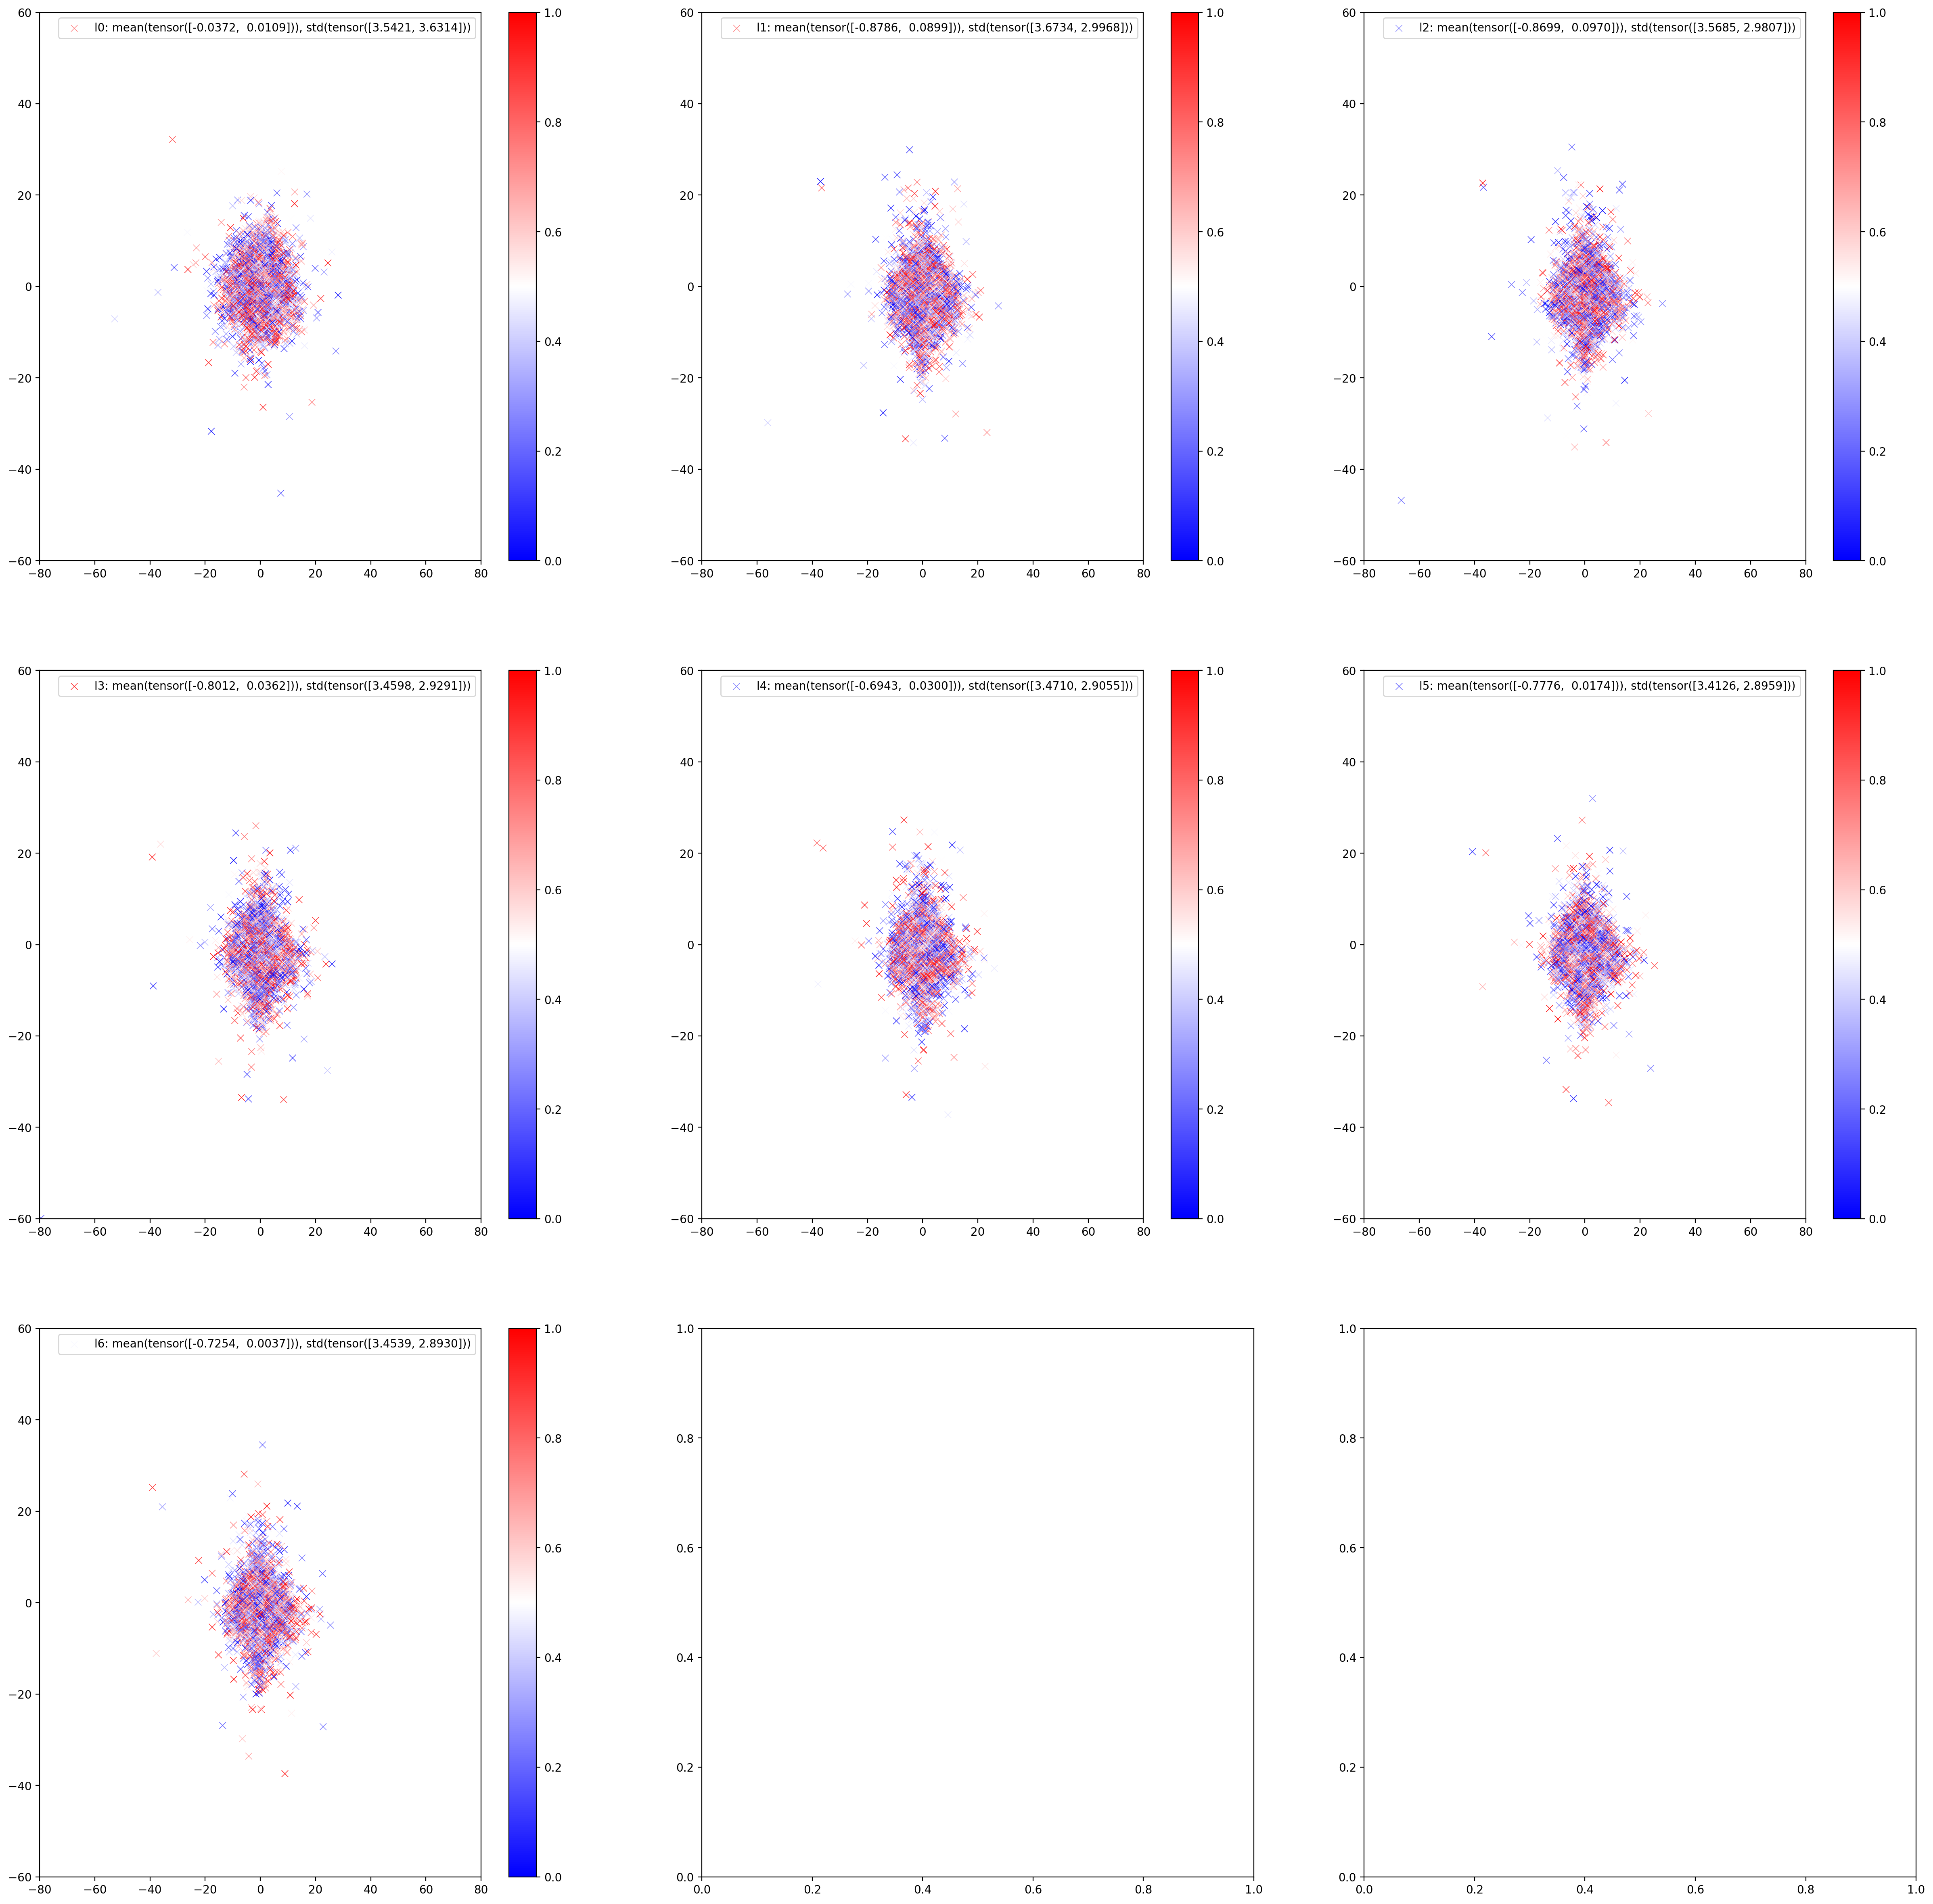

In [10]:
# Visualize
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(nrows=num_layers//3+1, ncols=3, figsize=(30,30))
for i in dis_gt.keys():
    if isinstance(dis_gt[i], list):
        dis_gt[i] = torch.cat(dis_gt[i], dim=0)
    if isinstance(prob_layers[i], list):
        prob_layers[i] = torch.cat(prob_layers[i], dim=0)
    min_dis = torch.min(torch.norm(dis_gt[0], dim=-1), dim=1).indices
    points = dis_gt[i][torch.arange(dis_gt[i].shape[0]), min_dis].clone()
    rank = torch.sort(prob_layers[i], dim=1)[1] / 64
    scores = rank[torch.arange(rank.shape[0]), min_dis].clone()
    std, mean = torch.std_mean(points, dim=0)
    row = i//ax.shape[1]
    col = i%ax.shape[1]
    ax[row, col].axis([-80, 80, -60, 60])
    sc = ax[row, col].scatter(points[:, 1], points[:, 0], c=scores, cmap="bwr", linewidth=0.5, marker='x', alpha=1, label=f"l{i}: mean({mean}), std({std})", vmin=0, vmax=1)
    ax[row, col].legend()
    fig.colorbar(sc, ax=ax[row, col])
plt.show(fig)

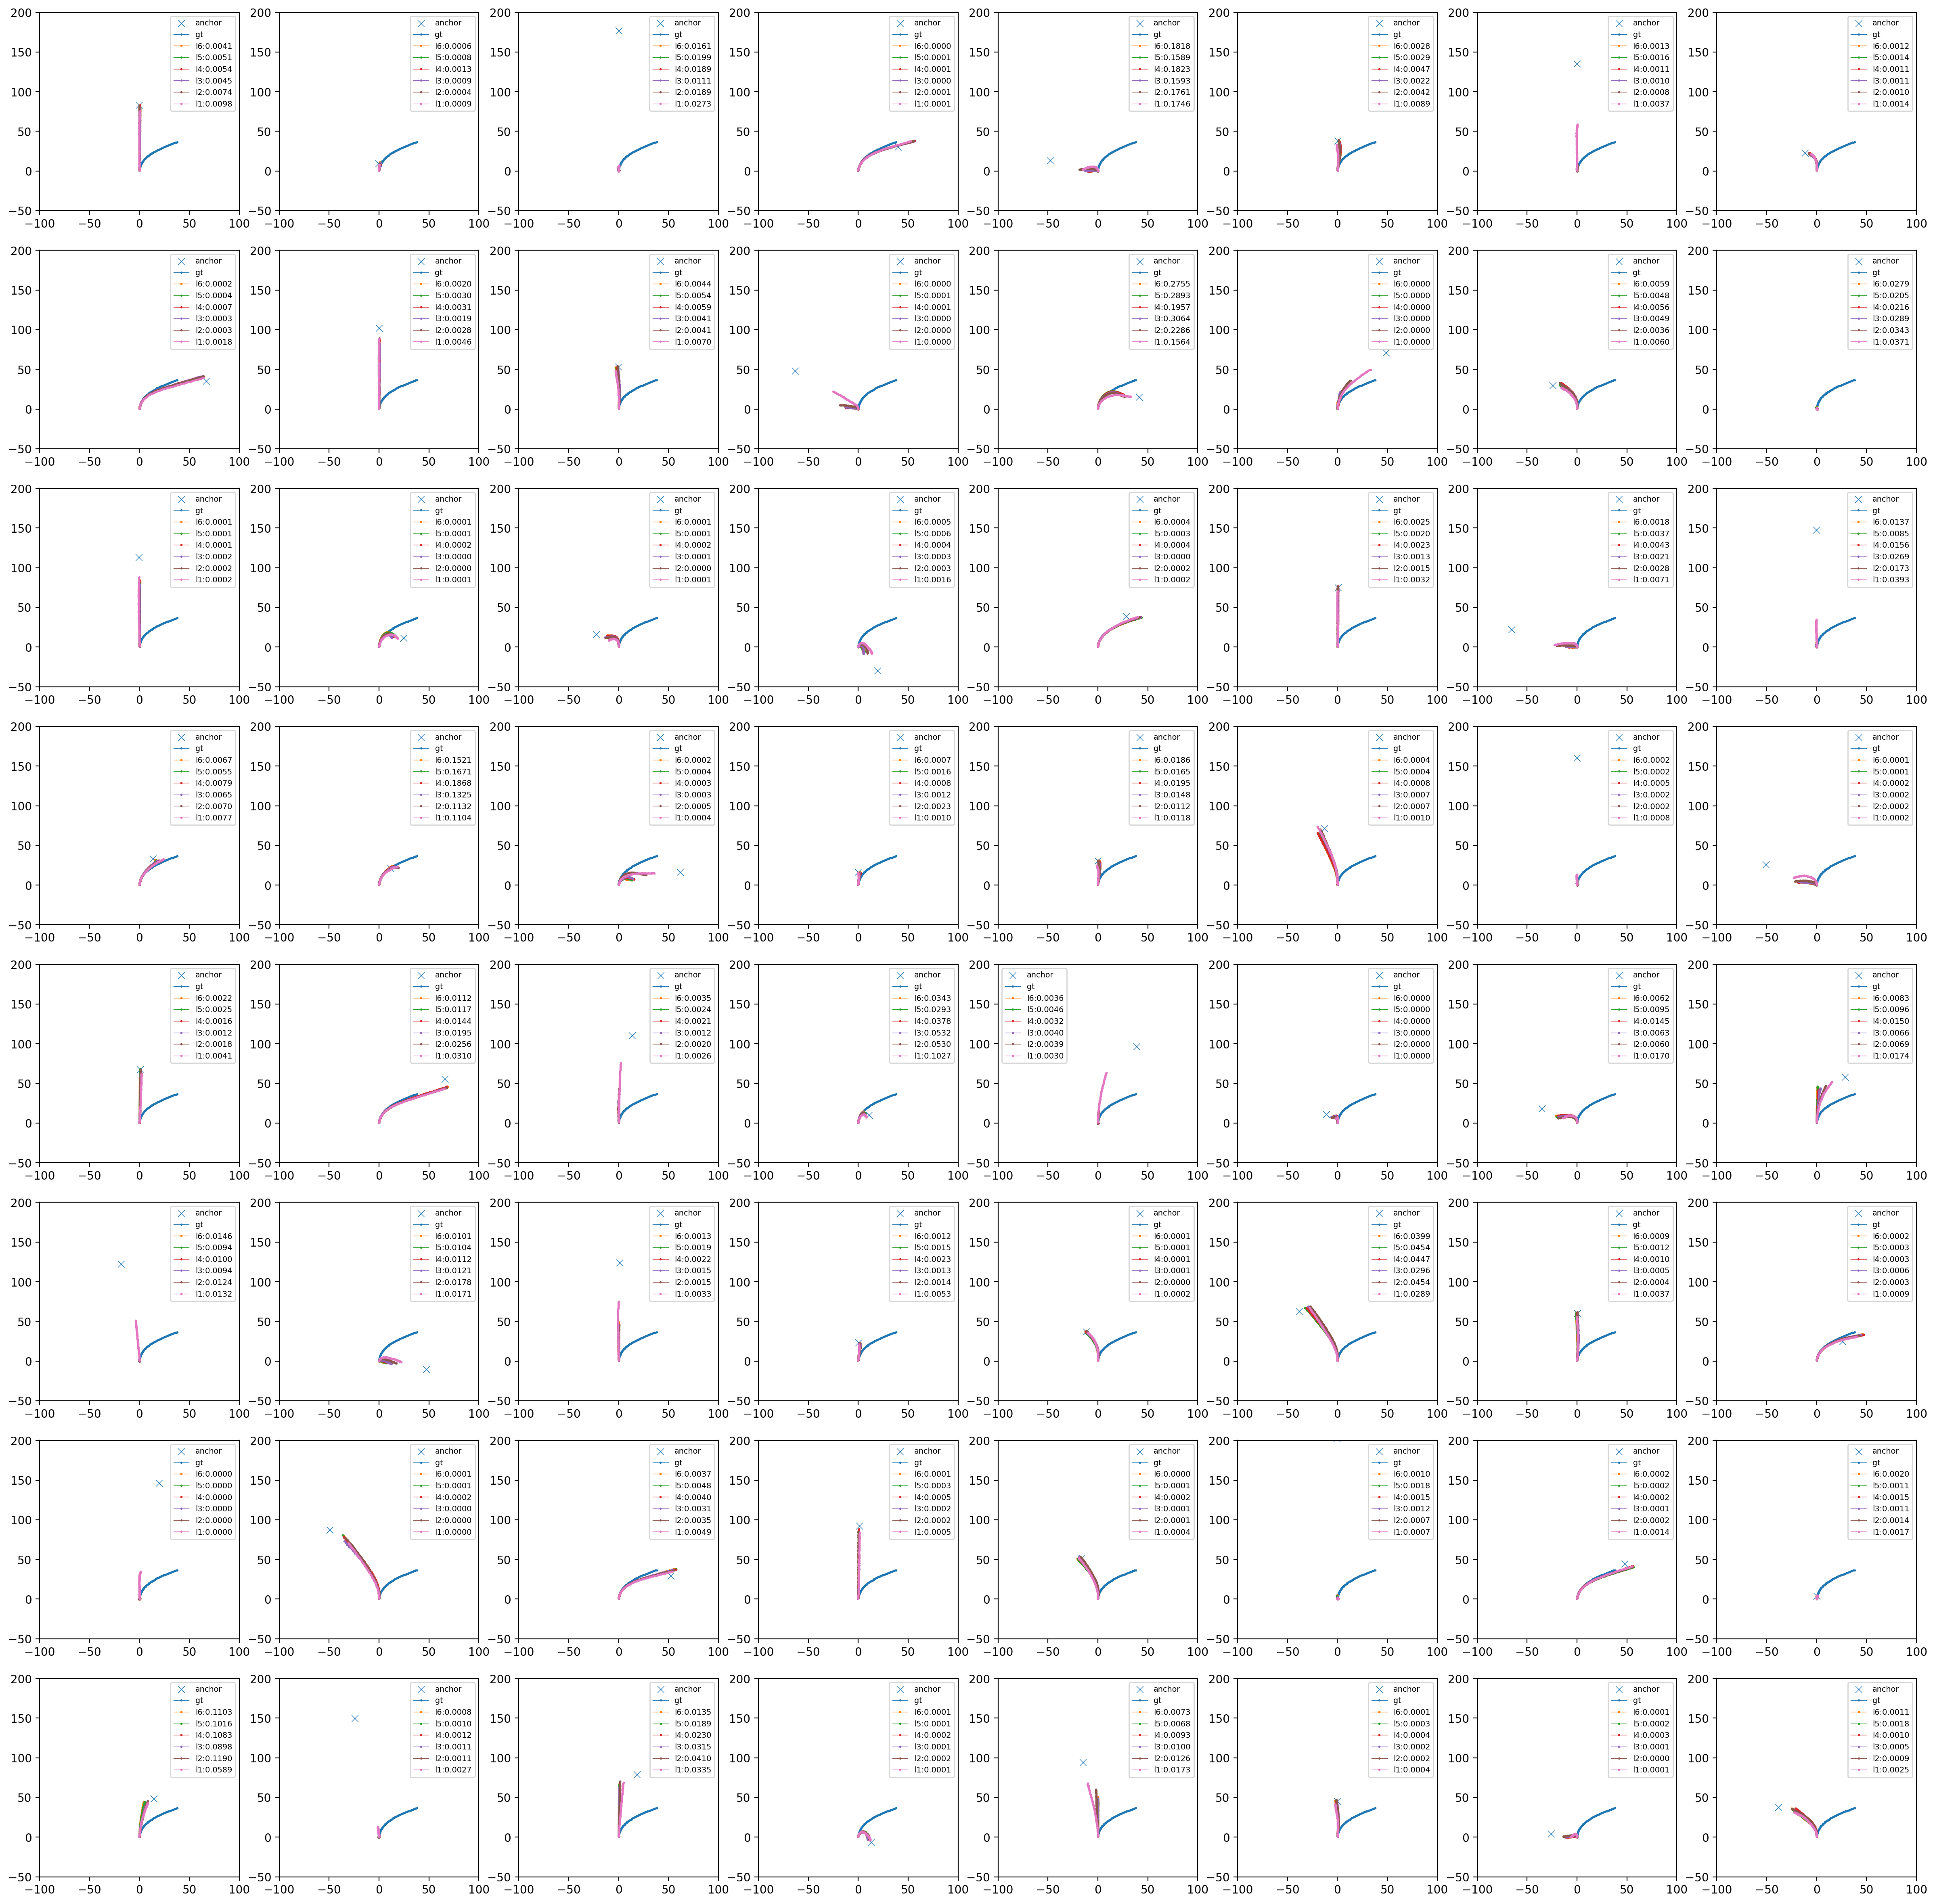

In [16]:
data_id = 0
agent_idx = 6
for i, batch_dict in enumerate(test_loader):
    if i == data_id:
        break

with torch.no_grad():
    batch_pred_dicts = model(batch_dict)
    
    input_dict = batch_dict['input_dict']
    center_gt_trajs = input_dict['center_gt_trajs'].cuda()
    center_gt_trajs_mask = input_dict['center_gt_trajs_mask'].cuda()
    center_gt_final_valid_idx = input_dict['center_gt_final_valid_idx'].long()
    
    pred_list = model.motion_decoder.forward_ret_dict['pred_list']
    intention_points = model.motion_decoder.forward_ret_dict['intention_points']  # (num_center_objects, num_query, 2)
    
    num_center_objects = center_gt_trajs.shape[0]
    center_gt_goals = center_gt_trajs[torch.arange(num_center_objects), center_gt_final_valid_idx, 0:2]  # (num_center_objects, 2)

# Visualize
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(30,30))
for m in range(64):
    row = m//ax.shape[1]
    col = m%ax.shape[1]
    ax[row, col].axis([-100, 100, -50, 200])
    ax[row, col].scatter(intention_points[agent_idx,m,1].cpu(), intention_points[agent_idx,m,0].cpu(), linewidth=0.5, marker='x', alpha=1, label="anchor")
    ax[row, col].plot(center_gt_trajs[agent_idx,:,1][center_gt_trajs_mask[agent_idx,:]>0].cpu(), center_gt_trajs[agent_idx,:,0][center_gt_trajs_mask[agent_idx,:]>0].cpu(), linewidth=0.5, marker='o', alpha=1, ms=1, label="gt")
    for n in range(len(pred_list)):
        i = len(pred_list)-1 - n
        pred_scores, pred_trajs = pred_list[i]  # (num_center_objects, num_query), (num_center_objects, num_query, timestep, 7)
        pred_scores = torch.softmax(pred_scores, dim=1)
        ax[row, col].plot(pred_trajs[agent_idx,m,:,1].cpu(), pred_trajs[agent_idx,m,:,0].cpu(), linewidth=0.5, marker='o', alpha=1, ms=1, label=f"l{i+1}:{pred_scores[0,m].item():.4f}")
    ax[row, col].legend(fontsize="x-small")
plt.show(fig)
plt.close(fig)